In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, plot_roc_curve
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import make_pipeline

# Part 1 ‐ Exploratory data analysis

## Loading Data

In [ ]:
path = '/content/drive/MyDrive/Springboard/searching job/ultimate_challenge/logins.json'
login_df = pd.read_json(path)
login_df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


## Data Information

### Login Data

In [ ]:
login_df.shape

(93142, 1)

In [ ]:
login_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [ ]:
login_df.isnull().sum()

login_time    0
dtype: int64

## Aggregate these login counts based on 15­minute time intervals

In [ ]:
login_df['login_time']= pd.to_datetime(login_df.login_time, unit='s')
login_df['count'] = 1
series = login_df.set_index(keys='login_time')['count']
series.tail()

login_time
1970-04-13 18:50:19    1
1970-04-13 18:43:56    1
1970-04-13 18:54:02    1
1970-04-13 18:57:38    1
1970-04-13 18:54:23    1
Name: count, dtype: int64

In [ ]:
counts_15min = series.resample('15T').sum()
counts_15min.head()

login_time
1970-01-01 20:00:00    2
1970-01-01 20:15:00    6
1970-01-01 20:30:00    9
1970-01-01 20:45:00    7
1970-01-01 21:00:00    1
Freq: 15T, Name: count, dtype: int64

In [ ]:
len(counts_15min)

9788

## Time seried

Text(0, 0.5, 'Login Counts')

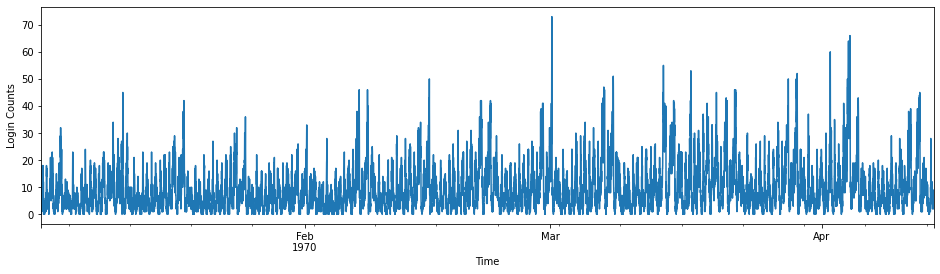

In [ ]:
fig, ax = plt.subplots(figsize=(16,4))
counts_15min.plot()
plt.xlabel('Time')
plt.ylabel('Login Counts')

* There is a seasonal pattern.
* The trend is not clear.


## Features of the demand

### Daily Login Frequency in every 15mins

In [ ]:
#Add a column of time 
login_count_df = pd.DataFrame({'counts_15min': counts_15min.values, 'time': pd.Series(counts_15min.index).dt.time})
login_count_df.head()

,counts_15min,time
0,2,20:00:00
1,6,20:15:00
2,9,20:30:00
3,7,20:45:00
4,1,21:00:00


Text(0, 0.5, 'Counts')

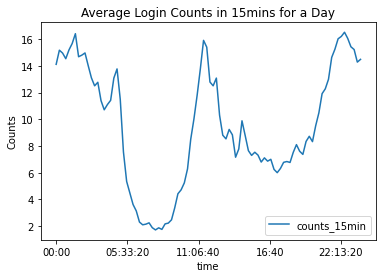

In [ ]:
login_count_df.groupby('time').mean().plot()
plt.title('Average Login Counts in 15mins for a Day')
plt.ylabel('Counts')

* There are two peaks of login counts during the day, during 22:00-1:30 and around 11:00, about 15 people in 15mins.

* At around 6:00-9:00 in the morning, the least people login, only about 2 people in 15min.

### Weekly Login Frequency in every 15mins

In [ ]:
login_count_df['day_of_week'] = pd.Series(series.index).dt.dayofweek
weekly_counts = login_count_df.groupby('day_of_week').mean()
weekly_counts 

,counts_15min
day_of_week,
0,8.450251
1,8.815175
2,10.590795
3,9.403238
4,9.117798
5,9.430428
6,10.309101


Text(0, 0.5, 'Counts')

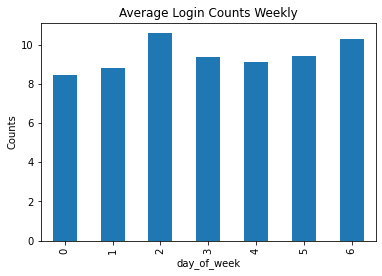

In [ ]:
weekly_counts.counts_15min.plot.bar()
plt.title('Average Login Counts Weekly')
plt.ylabel('Counts')

* 0=Monday, 6=Sunday
* On Wednesday and Sunday, the login frequencies in 15mins are higher than other days.
* Login frequencies on Monday is the lowest.

In [ ]:
weekly_login_counts = series.resample('1W').sum()
weekly_login_counts

login_time
1970-01-04    2374
1970-01-11    5217
1970-01-18    5023
1970-01-25    4751
1970-02-01    4744
1970-02-08    5572
1970-02-15    5915
1970-02-22    7035
1970-03-01    6554
1970-03-08    7398
1970-03-15    7338
1970-03-22    8955
1970-03-29    7285
1970-04-05    8095
1970-04-12    6491
1970-04-19     395
Freq: W-SUN, Name: count, dtype: int64

Text(0.5, 1.0, 'Total Counts of Login Weekly')

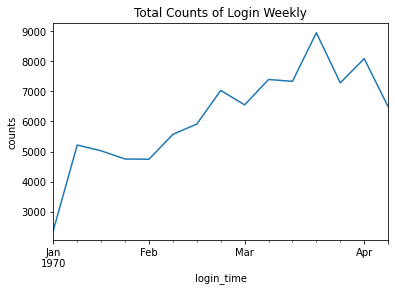

In [ ]:
weekly_login_counts[:15].plot()
plt.ylabel('counts')
plt.title('Total Counts of Login Weekly')

* The time series have an increasing trend over time weekly, but started to decrease at around 1970-03-29. 

# Part 2 ‐ Experiment and metrics design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.

However, a toll bridge, with a two­way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

__What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?__

__ANS:__


Suppose we can get the data of the record about the drivers crossing the bridge, then we can see if the number of driver crossing the bridge from Metropolis to Gotham during the evening or from Gotham to Metropolis during the day increase. I think this metric is useful beacuse the data is easy to get and easy to measure.

__Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:__

a. how you will implement the experiment

b. what statistical test(s) you will conduct to verify the significance of the observation

c. how you would interpret the results and provide recommendations to the city operations team along with any caveats.


__ANS:__

**a.** Develope the  hypotheses:

Null hypothesis:  reimbursing all toll costs dose not increase the number of driver crossing the bridge.

Alternative hypothesis: the number of driver crossing the bridge increase after reimbursing all toll costs.


**b.** I will use one-side z-test to verify the significance of the observation, and with significant level of 5%. 

**c.** Suppose we can N observations in the data set, and we have calculated the how many times the drivers crossing the bridge on average before and after the experiment, and recorded the value before the experiment as $\mu$ and the value after the experiment as $\bar{x}$. We can also calculate the standard deviation of the number of bridge crossings before the experiment, recorded as $\sigma$. 
According to the data above, we can calculate the z-score, then we can find the p-value from the z-test table. If p-value < 0.05, them we reject the null hypothesis and say reimbursing all toll costs increase the number of drivers crossing the bridge. Otherwise, experiment of reimbursing all toll costs dose not encourage driver partners to be available in both cities. 




# Part 3 ‐ Predictive modeling

## Data loading and information

In [ ]:
path = '/content/drive/MyDrive/Springboard/searching job/ultimate_challenge/ultimate_data_challenge.json'
ultimate_data = pd.read_json(path)
ultimate_data.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [ ]:
ultimate_data.shape

(50000, 12)

In [ ]:
ultimate_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [ ]:
ultimate_data.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


In [ ]:
ultimate_data.isnull().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64

## Data Cleaning

#### Removed duplicated rows

In [ ]:
duplicated_row_index = ultimate_data[ultimate_data.duplicated()].index
ultimate_data.drop(duplicated_row_index, axis=0, inplace=True)
ultimate_data.shape

(49992, 12)

#### Convert date columns to datetime and add a column 'active' indicating whether the user were “active” in the preceding 30 days

In [ ]:
ultimate_data['signup_date']=pd.to_datetime(ultimate_data.signup_date)
ultimate_data['last_trip_date']=pd.to_datetime(ultimate_data.last_trip_date)
ultimate_data['active']=((ultimate_data['last_trip_date']-ultimate_data['signup_date']).dt.days <=30).astype('int')
ultimate_data.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,1
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,0
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0


## Exploratory Data Analysis

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


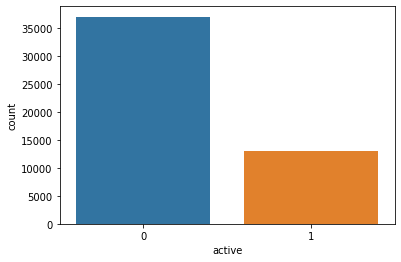

In [ ]:
sns.countplot(ultimate_data.active)

In [ ]:
#fraction of the observed users were retained
ultimate_data.active.sum()/len(ultimate_data.active)

0.2604216674667947

* The data set is imbalance, only about 1/4 of the data set is shown as 'active'.

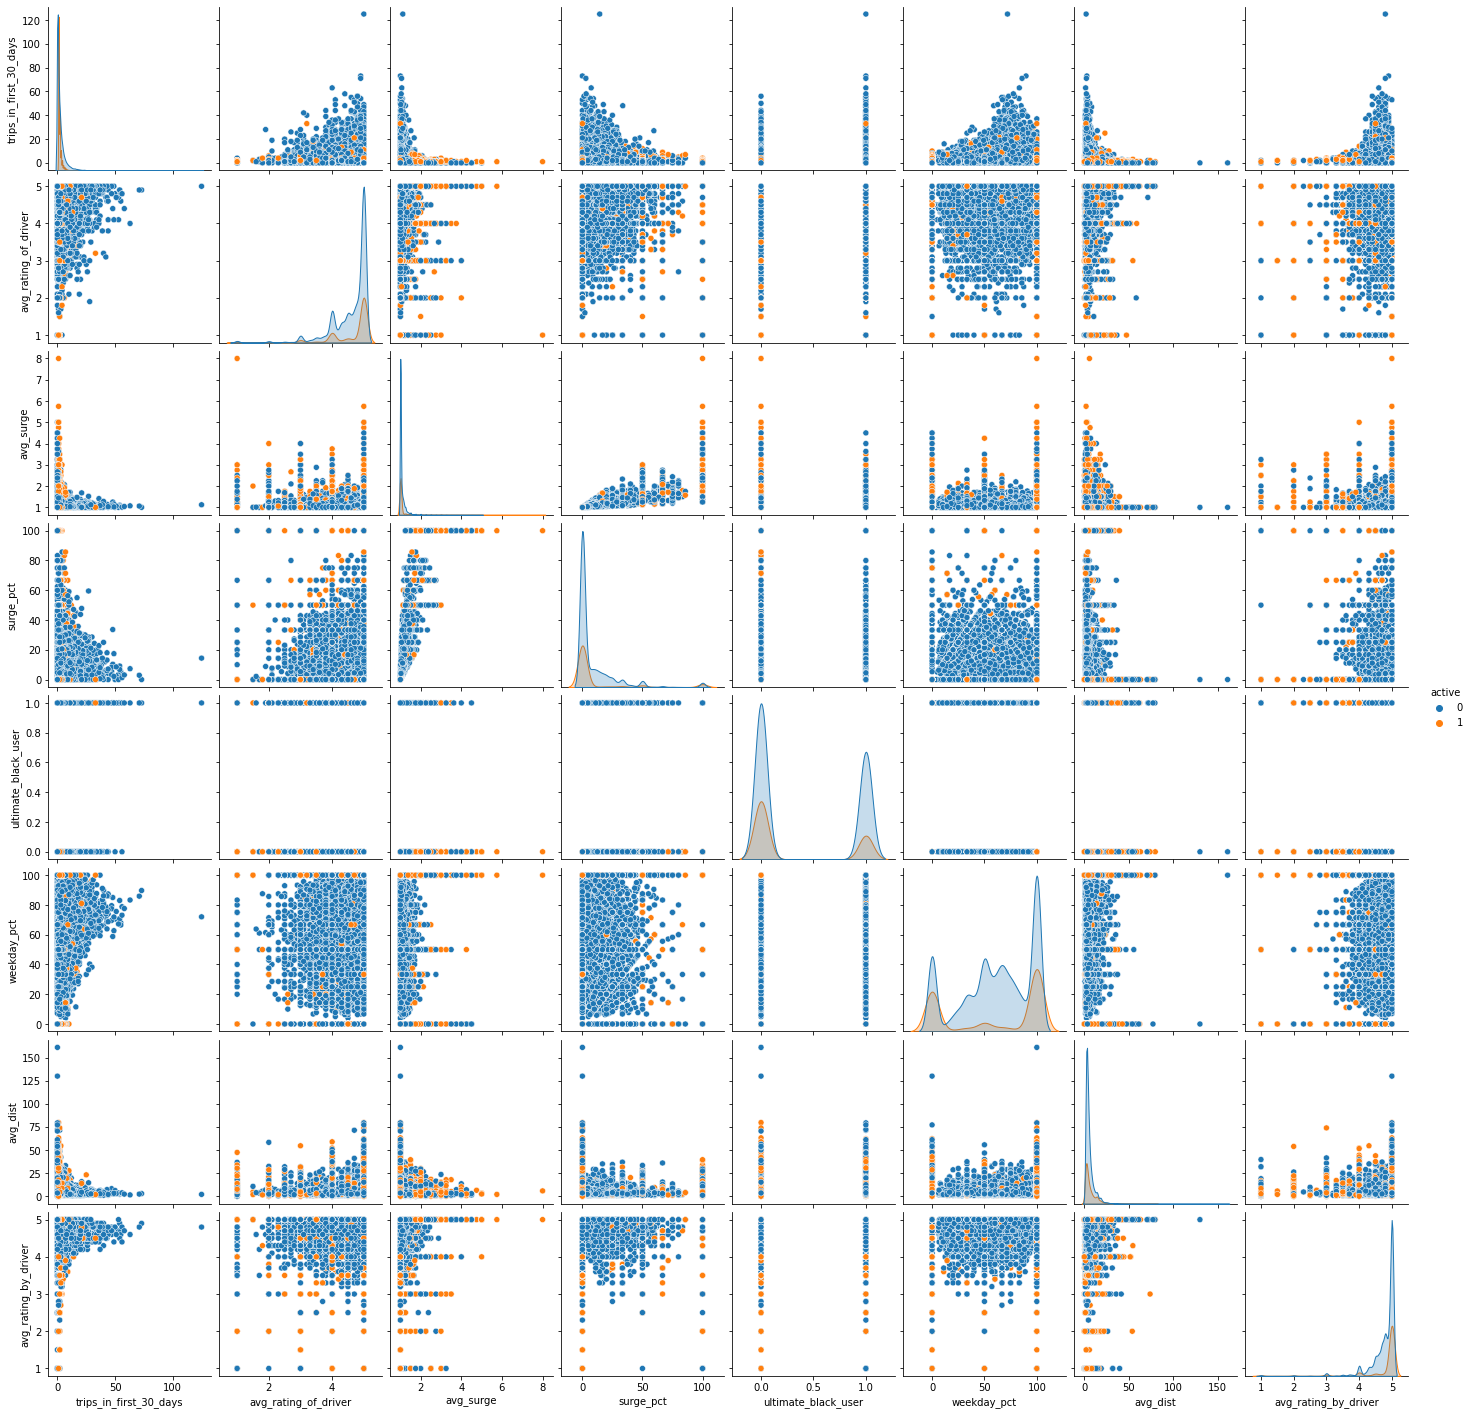

In [ ]:
sns.pairplot(ultimate_data, hue='active')

* There is not clear relationship between any two features according to the pair plot. 

In [ ]:
ultimate_data.columns

Index(['city', 'trips_in_first_30_days', 'signup_date', 'avg_rating_of_driver',
       'avg_surge', 'last_trip_date', 'phone', 'surge_pct',
       'ultimate_black_user', 'weekday_pct', 'avg_dist',
       'avg_rating_by_driver', 'active'],
      dtype='object')

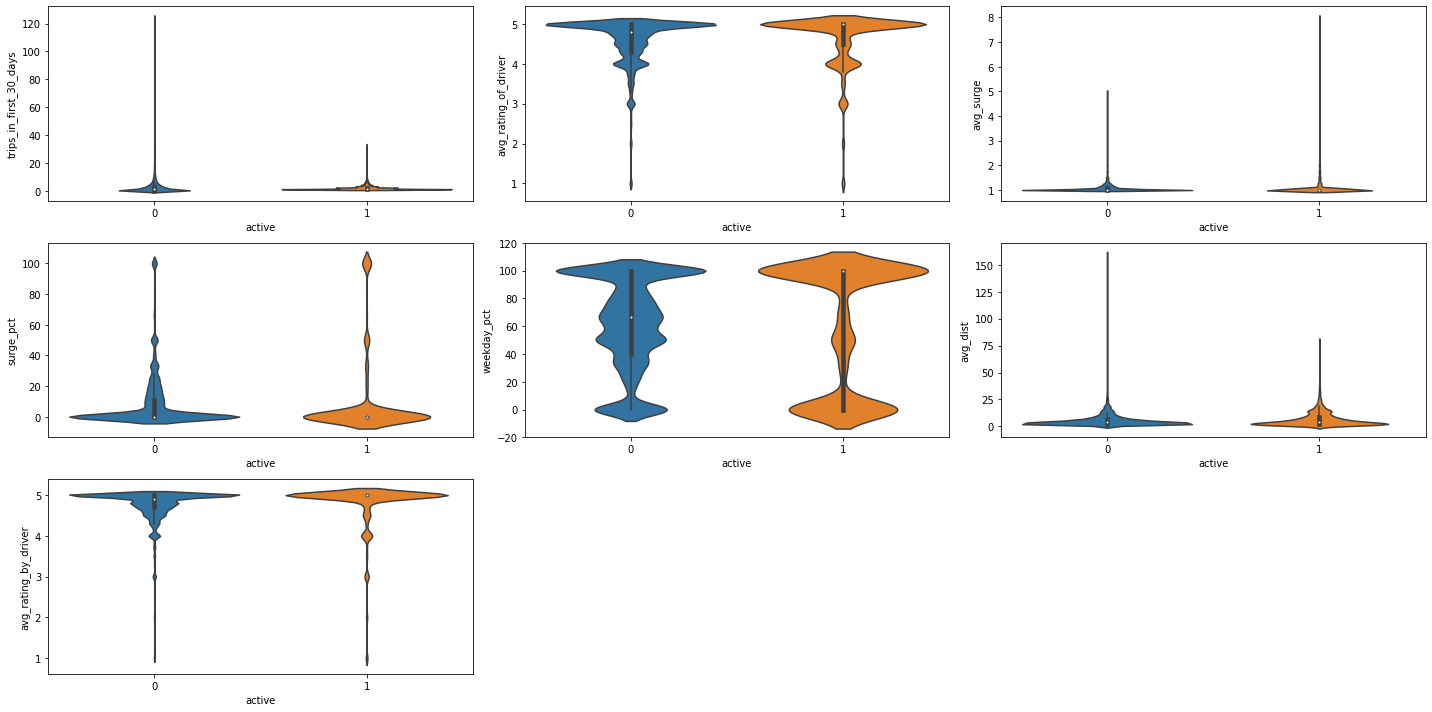

In [ ]:
cols_discrete = ['trips_in_first_30_days','avg_rating_of_driver','avg_surge','surge_pct','weekday_pct','avg_dist','avg_rating_by_driver']

fig = plt.figure(figsize=(20,10))
for i, col in enumerate(cols_discrete):
  ax1 = fig.add_subplot(3,3,i+1)
  sns.violinplot(data=ultimate_data,y=col,x='active')

plt.tight_layout()

* The distribution of the discrete features sorted by the column 'active' are very close to each other except the feature 'weekday_pct'. The feature 'weekday_pct' have a lot more values land on the range between 20-80.

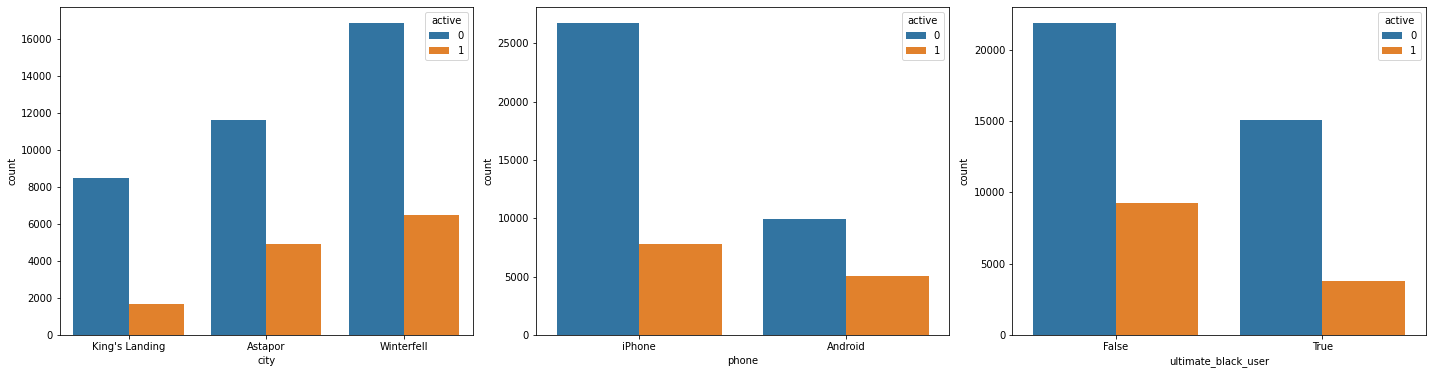

In [ ]:
col_cate = ['city', 'phone','ultimate_black_user']
fig = plt.figure(figsize=(20,10))
for i, col in enumerate(col_cate):
  ax1 = fig.add_subplot(2,3,i+1)
  sns.countplot(data=ultimate_data,x=col,hue='active',)

  plt.tight_layout()

* Winterfell city has the most 'active' user, and King's Landing has least
* For those users did not take Ultimate Black, most of them are 'active'

#### Fill missing values for each column using its own most frequent value

In [ ]:
ultimate_data.fillna(ultimate_data.mode().iloc[0],inplace=True)

In [ ]:
ultimate_data.shape

(49992, 13)

## Pre-processing

In [ ]:
# Drop the columns of data
df= ultimate_data.drop(columns=['signup_date','last_trip_date'])
df.shape

(49992, 11)

In [ ]:
df['ultimate_black_user'] = df.ultimate_black_user.astype('int')

In [ ]:
# Get X and y
X = df.drop(columns='active',axis=1)
y = df['active']

In [ ]:
# Get dummy variable
X = pd.get_dummies(X)
X.shape

(49992, 13)

In [ ]:
# Split the data set to get train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## Create the predictive model

### Use grid search to find the optimal hyperparameters for the Gradient Boosting Classifier

In [ ]:
GBC_pipe = make_pipeline(
    SelectKBest(f_regression),
    GradientBoostingClassifier())

GBC_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'selectkbest', 'gradientboostingclassifier', 'selectkbest__k', 'selectkbest__score_func', 'gradientboostingclassifier__ccp_alpha', 'gradientboostingclassifier__criterion', 'gradientboostingclassifier__init', 'gradientboostingclassifier__learning_rate', 'gradientboostingclassifier__loss', 'gradientboostingclassifier__max_depth', 'gradientboostingclassifier__max_features', 'gradientboostingclassifier__max_leaf_nodes', 'gradientboostingclassifier__min_impurity_decrease', 'gradientboostingclassifier__min_impurity_split', 'gradientboostingclassifier__min_samples_leaf', 'gradientboostingclassifier__min_samples_split', 'gradientboostingclassifier__min_weight_fraction_leaf', 'gradientboostingclassifier__n_estimators', 'gradientboostingclassifier__n_iter_no_change', 'gradientboostingclassifier__presort', 'gradientboostingclassifier__random_state', 'gradientboostingclassifier__subsample', 'gradientboostingclassifier__tol', 'gradientboostingclassifier__val

In [ ]:
k = [i for i in range(1, len(X_train.columns)+1)]

param_grid = {'selectkbest__k':k, 
#              'gradientboostingclassifier__learning_rate':[0.09, 0.10,0.11,0.12], 
              'gradientboostingclassifier__n_estimators':[100, 120, 140 ],
              'gradientboostingclassifier__max_depth':[5,7,9],
#              'gradientboostingclassifier__max_features':['auto', 'sqrt', 'log2']
              }

GBC_gird_cv = GridSearchCV(GBC_pipe, 
                           param_grid,
                           scoring = 'f1',
                           cv=5,
                           n_jobs=-1)
GBC_gird_cv.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('selectkbest',
                                        SelectKBest(k=10,
                                                    score_func=<function f_regression at 0x7f26cd0ec5f0>)),
                                       ('gradientboostingclassifier',
                                        GradientBoostingClassifier(ccp_alpha=0.0,
                                                                   criterion='friedman_mse',
                                                                   init=None,
                                                                   learning_rate=0.1,
                                                                   loss='deviance',
                                                                   max_depth=3,
                                                                   max_features=None,
                                       

In [ ]:
GBC_gird_cv.best_score_

0.8823243103001573

In [ ]:
# Get the best hyperparameters
GBC_gird_cv.best_params_

{'gradientboostingclassifier__max_depth': 7,
 'gradientboostingclassifier__n_estimators': 140,
 'selectkbest__k': 13}

* The best k is 13, that is all features of the data set are useful in this model.

#### Applied the optimal hyperparameters to the Gradient Boosting Classifier

In [34]:
GBC=GradientBoostingClassifier(max_depth=7, n_estimators=140)
GBC.fit(X_train, y_train)
y_pred = GBC_pipe.predict(X_test)

Text(33.0, 0.5, 'True Label')

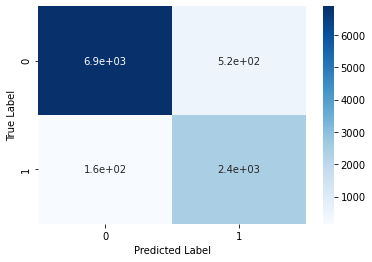

In [32]:
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

In [36]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.98      0.93      0.95      7396
           1       0.83      0.94      0.88      2603

    accuracy                           0.93      9999
   macro avg       0.90      0.93      0.92      9999
weighted avg       0.94      0.93      0.93      9999



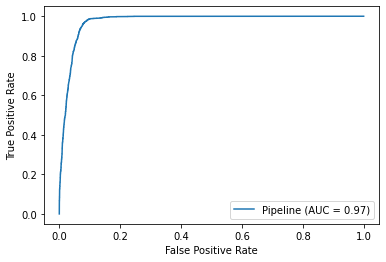

In [37]:
ax = plt.gca()
fig = plot_roc_curve(GBC_pipe, X_test,y_test,ax=ax)
plt.show()

* The Gradient Boosting Classifier combines weak "learners" into a single strong learner in an iterative fashion. I am using this model because there is on clear relationship between any two features and between feature and the labels (the column 'active'). It would be hard to find a single learner like losistic regression to learn the pattern of the data. Therefore, a model that combined with many weaker 'learners' may be more helpful to classify the data set. 

* Alternatives I considered are Random Forest, SVM, K-nn...

* Because of the imbalance of the observations, I use f1-score as the main metric. The f1-score for the Gradient Boosting Classifier is about 0.915, which show that the model for this data set is valid.  

## How Ultimate might leverage the insights gained from the model to improve its long­term rider retention

In [41]:
feature_importances_df = pd.DataFrame({'feature': X.columns, 'feature_importances':GBC.feature_importances_})
feature_importances_df = feature_importances_df.sort_values('feature_importances', ascending=False)
feature_importances_df

,feature,feature_importances
7,avg_rating_by_driver,0.319332
0,trips_in_first_30_days,0.295953
5,weekday_pct,0.245332
3,surge_pct,0.048961
6,avg_dist,0.031620
1,avg_rating_of_driver,0.023617
9,city_King's Landing,0.011689
2,avg_surge,0.009807
4,ultimate_black_user,0.006386
12,phone_iPhone,0.002500


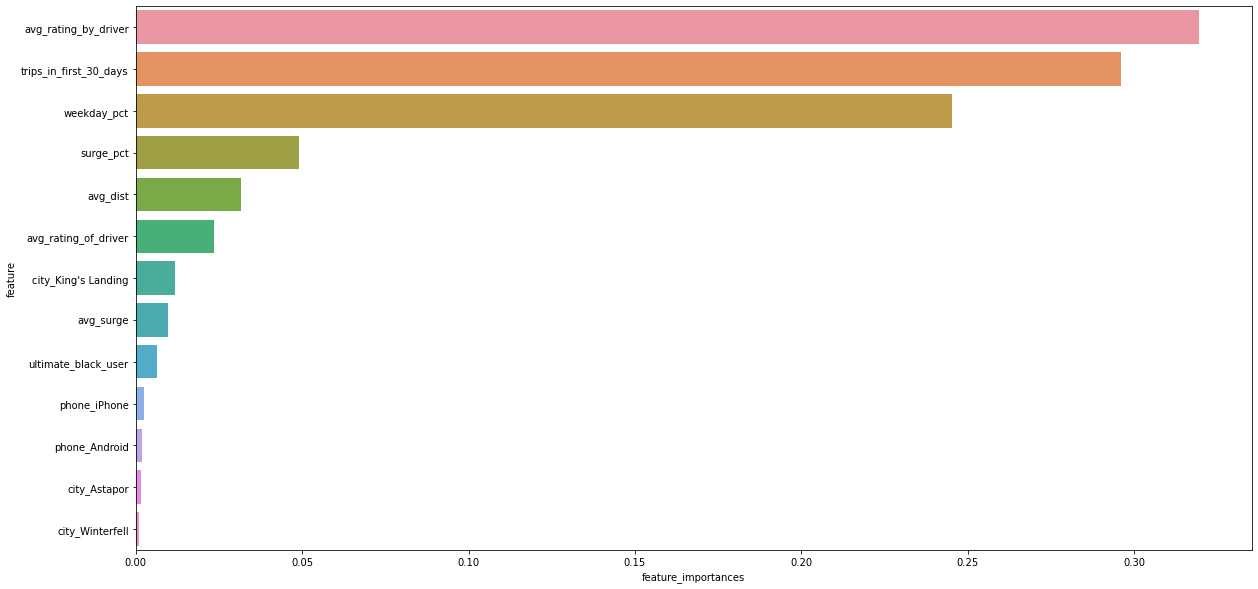

In [44]:
fig = plt.figure(figsize=(20,10))
sns.barplot(data=feature_importances_df,y='feature',x='feature_importances')

* The three most important features are avg_rating_by_driver, trips_in_first_30_days, weekday_pct, they are providing about 85% of informations for the Gradient Boosting Classifier.

* To improve its long­term rider retention, the company should try to leave the user good impression, like giving the the new users discount, or very good service.  